In [22]:
%matplotlib inline
import datetime as dt
import pandas as pd
from matplotlib import pyplot as plt
import os
import sys
sys.path.append("/home/konajain/code/lobSimulations")
from hawkes import dataLoader
import numpy as np
import time

In [70]:
ric = "INTC"

# Spread 

In [64]:
samplingTime = 60

In [65]:
spreads = []
for j in pd.date_range(dt.date(2019,1,2), dt.date(2019,12,31)):
    l = dataLoader.Loader(ric, j, j, nlevels = 1, dataPath = "/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/")
    data = l.load()
    if len(data):
        data = data[0]
    else:
        continue
        
    data['spread'] = data['Ask Price 1'] - data['Bid Price 1']
    data['timeDiff'] = data['Time'].diff()
    data['spreadTwa'] = data['spread']*data['timeDiff']
    data['id'] = data['Time'].apply(lambda x: int((x - 34200)//samplingTime))
    twaspread = (data[['spreadTwa', 'id']].groupby('id').sum().values)/samplingTime
    spreads.append(twaspread)

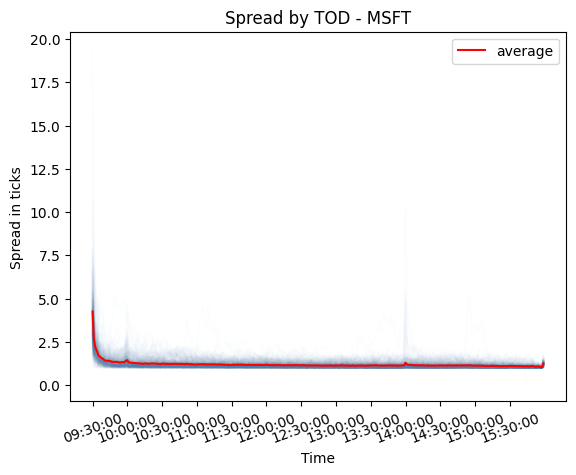

In [137]:
%matplotlib inline
plt.figure()
for s in spreads:
    plt.plot(100*s, alpha = 0.01, color = "steelblue")
plt.plot(np.average(100*np.array([s for s in spreads if len(s) == 390]), axis = 0), color="r", label = "average")
plt.xlabel("Time")
plt.ylabel("Spread in ticks")
plt.legend()
plt.title("Spread by TOD - " + ric)
plt.xticks(ticks = np.arange(0, 23400//samplingTime, 1800//samplingTime), labels = [time.strftime('%H:%M:%S', time.gmtime(x)) for x in 9.5*3600 + samplingTime*np.arange(0, 23400//samplingTime, 1800//samplingTime)], rotation = 20)
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_SpreadTOD.png")
plt.show()

In [138]:
np.average(np.average(100*np.array([s for s in spreads if len(s) == 390]), axis = 0))

1.1961077595910226

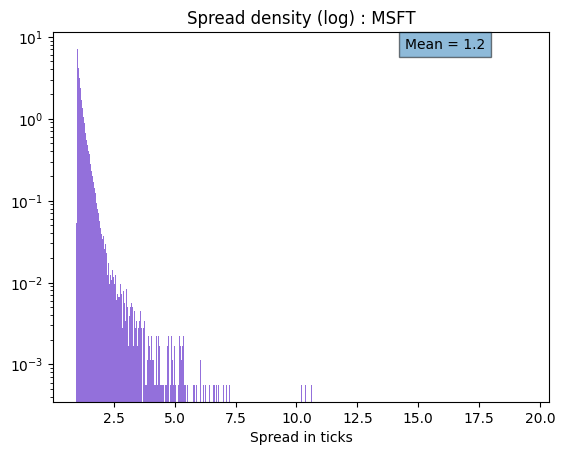

In [157]:
plt.figure()
a = plt.hist(np.ravel(100*np.array([s for s in spreads if len(s) == 390])), bins = 1000, density = True, color="mediumpurple")
plt.xlabel("Ratio")
plt.xlabel("Spread in ticks")
plt.yscale("log")
plt.text(a[1][-1]*0.75, np.max(a[0]), "Mean = " + str(np.round(np.average(np.average(100*np.array([s for s in spreads if len(s) == 390]), axis = 0)),2)), bbox=dict(alpha=0.5))

plt.title("Spread density (log) : " + ric)
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_SpreadDistriLog.png")

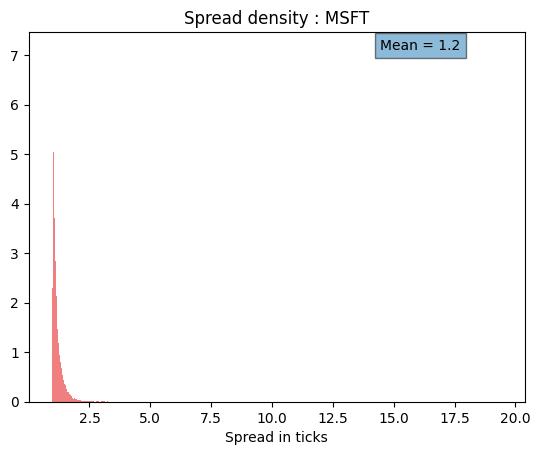

In [156]:
plt.figure()
a =plt.hist(np.ravel(100*np.array([s for s in spreads if len(s) == 390])), bins = 1000, density = True, color="lightcoral")
plt.xlabel("Ratio")
plt.xlabel("Spread in ticks")
plt.text(a[1][-1]*0.75, np.max(a[0]), "Mean = " + str(np.round(np.average(np.average(100*np.array([s for s in spreads if len(s) == 390]), axis = 0)),2)), bbox=dict(alpha=0.5))
plt.title("Spread density : " + ric)
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_SpreadDistri.png")

In [4]:
import gc
gc.collect()

714

# Shape of the book

In [80]:
# prices = np.arange(0,100)
final_res = {}
final_res_far = {}
for j in pd.date_range(dt.date(2019,1,2), dt.date(2019,1,15)):
    if j == dt.date(2019,1,9): continue
    l = dataLoader.Loader(ric, j, j, nlevels = 10, dataPath = "/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/")
    data = l.load()
    master_dict, master_dict_far = {}, {}
    if len(data):
        data = data[0]
    else:
        continue
    data['timeDiff'] = data['Time'].diff()
    data['total v_a'] = data[["Ask Size " + str(i) for i in range(1,11) ]].sum(axis=1)
    data['total v_b'] = data[["Bid Size " + str(i) for i in range(1,11) ]].sum(axis=1)
    data['mid'] = (data['Ask Price 1'] + data['Bid Price 1'])*0.5
    for i in range(10,0, -1):
        data["Ask Size " + str(i)] = data["Ask Size " + str(i)]/data['total v_a']
        data["Bid Size " + str(i)] = data["Ask Size " + str(i)]/data['total v_b']
        data["Ask Price1 " + str(i)] = np.round(200*(data["Ask Price " + str(i)] - data['mid'])).astype(int)
        data["Bid Price1 " + str(i)] = np.round(200*(data['mid'] - data["Bid Price " + str(i)])).astype(int)
        data["Ask Price2 " + str(i)] = np.round(200*(data["Ask Price " + str(i)] - data["Bid Price 1"])).astype(int)
        data["Bid Price2 " + str(i)] = np.round(200*(data['Ask Price 1'] - data["Bid Price " + str(i)])).astype(int)
        data['tmp'] = data['Ask Size ' + str(i)]*data['timeDiff']
        data_dict = (data.groupby("Ask Price1 " + str(i))['tmp'].sum()/23400).to_dict()
        data_dict_far = (data.groupby("Ask Price2 " + str(i))['tmp'].sum()/23400).to_dict()
        # print(sum(data_dict.values()))
        for k, v in data_dict.items():
            master_dict[k] = master_dict.get(k, [])+ [v]
        for k, v in data_dict_far.items():
            master_dict_far[k] = master_dict_far.get(k, [])+ [v]
        data['tmp'] = data['Bid Size ' + str(i)]*data['timeDiff']
        data_dict = (data.groupby("Bid Price1 " + str(i))['tmp'].sum()/23400).to_dict()
        data_dict_far = (data.groupby("Bid Price2 " + str(i))['tmp'].sum()/23400).to_dict()
        for k, v in data_dict.items():
            master_dict[k] = master_dict.get(k, [])+ [v]
        for k, v in data_dict_far.items():
            master_dict_far[k] = master_dict_far.get(k, [])+ [v]
    res_dict = {}
    std_dict = {}
    for k,v in master_dict.items():
        res_dict[k] = np.average(v)
        std_dict[k] = np.std(v)
        final_res[k] = final_res.get(k, [])+ [res_dict[k]]
    res_dict_far = {}
    std_dict_far = {}
    for k,v in master_dict_far.items():
        res_dict_far[k] = np.average(v)
        std_dict_far[k] = np.std(v)
        final_res_far[k] = final_res_far.get(k, [])+ [res_dict_far[k]]

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-02_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/1336786885.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-03_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-04_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-07_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/1336786885.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-08_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/1336786885.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-10_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/1336786885.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-11_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/1336786885.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-14_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/1336786885.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/AAPL_2019-01-15_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/1336786885.py:7: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


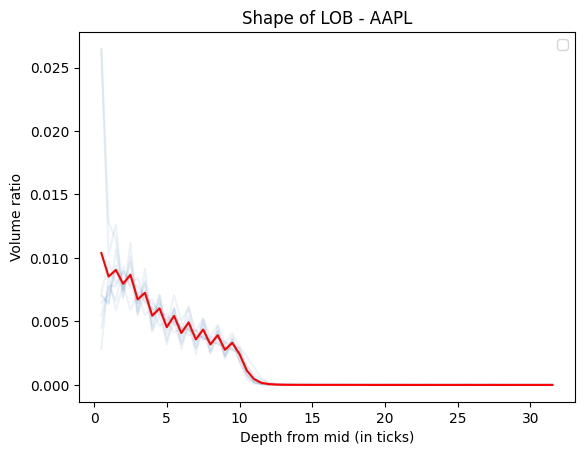

In [81]:
%matplotlib inline
plt.figure()
# plt.plot(np.arange(0,100,2)/2, [(res_dict[k] + res_dict[k+1])/2 for k in range(0,100,2)])
key0 = list(final_res.keys())[0]
for i in range(len(final_res[key0])):
    x, y = [], []
    for k in range(1,250):
        if (final_res.get(k, None) is not None)and(len(final_res.get(k, [])) == len(final_res[key0])):
            x+= [k]
            y+= [final_res[k][i]]
    x = np.array(x)
    plt.plot(x/2, y, alpha = 0.1, color = "steelblue")
plt.plot(x/2, [np.average(final_res[k]) for k in x], color="r")
# plt.fill_between(np.arange(0,100)/2, [np.max([1e-3,res_dict[k] - std_dict[k]]) for k in range(100)], [res_dict[k] + std_dict[k] for k in range(100)], alpha = 0.1, color="b")
# plt.yscale("log")
plt.xlabel("Depth from mid (in ticks)")
plt.ylabel("Volume ratio")
plt.legend()
plt.title("Shape of LOB - " + ric)
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_Shape.png")

In [77]:
final_res

{19: [0.0028229184102461, 0.0031656222051986336, 0.003810843523965734],
 20: [0.00300607820752692, 0.001938381788785427, 0.001786857801717027],
 21: [0.002203078247160232, 0.0015277126222750536, 0.000773600964005343],
 22: [0.0013924448864127002, 0.0007691834720137487, 0.00018992194643649817],
 23: [0.0004936438033436458, 0.0004215429758422114, 9.392738926566115e-05],
 24: [0.00015029392668017765, 0.00019336977719570678, 2.6841706433056166e-05],
 25: [5.2446867908110844e-05, 9.650064292149385e-05, 2.029560387437313e-05],
 26: [2.6724985159136462e-05, 4.757384271670813e-05, 9.134923207095384e-06],
 27: [1.4839858201579406e-05, 2.711324207972073e-05, 1.1714795177805399e-05],
 28: [1.258256005038108e-05, 1.733918846488537e-05, 9.013626049551808e-06],
 29: [6.665343954515651e-06, 1.4536317924069836e-05, 5.421575211187872e-06],
 30: [7.300944330091587e-06, 9.385936538159413e-06, 3.0674595068359166e-06],
 31: [6.640711283431174e-06, 7.855955171353631e-06, 3.895770922271368e-06],
 32: [7.6906

In [ ]:
# plt.figure()
# # plt.plot(np.arange(0,100,2)/2, [(res_dict[k] + res_dict[k+1])/2 for k in range(0,100,2)])
# for i in range(len(final_res_far[50])-1):
#     plt.plot(np.arange(2,250,2)/2, [final_res_far[k][i] for k in range(2,250,2)], alpha = 0.1, color = "steelblue")
# plt.plot(np.arange(2,250,2)/2, [np.average(final_res_far[k]) for k in range(2,250,2)], color="r")
# # plt.fill_between(np.arange(0,100)/2, [np.max([1e-3,res_dict[k] - std_dict[k]]) for k in range(100)], [res_dict[k] + std_dict[k] for k in range(100)], alpha = 0.1, color="b")
# # plt.yscale("log")
# plt.xlabel("Depth from far touch (in ticks)")
# plt.ylabel("Volume ratio")
# plt.legend()
# plt.title("Shape of LOB - " + ric)
# plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_ShapeFT.png")

In [ ]:
plt.figure()
pctiles = {}
percentiles = [0.1,0.25, 0.5, 0.75, 0.9, 0.99]
for i in range(len(final_res[key0])):
    x, y = [], []
    for k in range(1,250):
        if (final_res.get(k, None) is not None)and(len(final_res.get(k, [])) == len(final_res[key0])):
            x+= [k]
            y+= [final_res[k][i]]
    x = np.array(x)
    vols = np.array(y)
    volsNorm = vols/np.sum(vols)
    cumVols = np.cumsum(volsNorm)
    
    ticks = x/2
    for p in percentiles:
        idx = np.where(cumVols >= p)[0][0]
        # print("Percentile " + str(100*p) + " at " + str(ticks[idx]) + " ticks from mid") 
        pctiles[p] = pctiles.get(p, []) + [ticks[idx]]
# print("Perc Mean Std")
# for p in percentiles:
#     print(100*p, np.round(np.mean(pctiles[p]),1), np.round(np.std(pctiles[p]),2))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)

for p in percentiles[:-1]:
    plt.plot(pctiles[p],  label=str(100*p) + "th percentile : " + str(np.round(np.mean(pctiles[p]),1)) +" +- " + str(np.round(np.std(pctiles[p]),2)), alpha = 0.5)
    # plt.text(0, 10*p, )
plt.title("Shape of Book Percentiles Stationarity : "+ ric)
plt.legend()
plt.xlabel("Days")
plt.ylabel("Depth in ticks")
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_ShapeTimeSeries.png")

# Sparse Book

In [ ]:
res, res_distr, wts_distr = {}, {}, {}
for j in pd.date_range(dt.date(2019,1,2), dt.date(2019,12,31)):
    if j == dt.date(2019,1,9): continue
    l = dataLoader.Loader(ric, j, j, nlevels = 10, dataPath = "/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/")
    data = l.load()
    if len(data):
        data = data[0]
    else:
        continue
    data['timeDiff'] = data['Time'].diff()
    for i in range(2,11):
        data['tmp'] = data["Ask Price " + str(i)] - data["Ask Price " + str(i-1)] - 0.01
        res[i-1] = res.get(i-1, []) + [np.sum(data['tmp']*data['timeDiff'])/23400]
        res_distr[i-1] = np.append(res_distr.get(i-1, []), data['tmp'])
        wts_distr[i-1] = np.append(wts_distr.get(i-1, []), data['timeDiff'])
        data['tmp'] = data["Bid Price " + str(i)] - data["Bid Price " + str(i-1)] + 0.01
        res[i-1] = res.get(i-1, []) + [np.abs(np.sum(data['tmp']*data['timeDiff'])/23400)]
        res_distr[i-1] = np.append(res_distr.get(i-1, []), np.abs(data['tmp']))
        wts_distr[i-1] = np.append(wts_distr.get(i-1, []), data['timeDiff'])

In [ ]:
print(ric)
for i in range(1,10):
    print("Avg number of empty levels between top + " + str(i-1) + " to top + " + str(i) +" " + str(np.round(100*np.mean(res[i]),2)) + " +- " + str(np.round(100*np.std(res[i]),2)))

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
for i in range(1,10):
    plt.hist(100*res_distr[i], weights = np.nan_to_num(wts_distr[i]) , bins = np.arange(25), density =True, alpha = 0.2, label ="Top + " +str(i-1) + " to Top + " + str(i)+ " Median : " + str(np.round(100*np.median(res[i]),2))+" Mean : " + str(np.round(100*np.mean(res[i]),2)) + " +- " + str(np.round(100*np.std(res[i]),2)))
# plt.ylabel("Ratio")
plt.xlabel("Number of Empty levels")
plt.legend()
# plt.xscale("log")
# plt.yscale("log")
# plt.text(150, 0.025, "Mean = " + str(np.round(np.average(np.average(100*np.array([s for s in spreads if len(s) == 390]), axis = 0)),2)), bbox=dict(alpha=0.5))
plt.title("Empty Levels density : " + ric)
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_SparsityDistri.png")

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
for i in range(1,10):
    plt.hist(100*res_distr[i], weights = np.nan_to_num(wts_distr[i]), bins = np.arange(200), density = True, alpha = 0.2, label ="Top + " +str(i-1) + " to Top + " + str(i)+ " Median : " + str(np.round(100*np.median(res[i]),2))+" Mean : " + str(np.round(100*np.mean(res[i]),2)) + " +- " + str(np.round(100*np.std(res[i]),2)))
# plt.ylabel("Ratio")
plt.xlabel("Number of Empty levels")
plt.legend()
# plt.xscale("log")
plt.yscale("log")
# plt.text(150, 0.025, "Mean = " + str(np.round(np.average(np.average(100*np.array([s for s in spreads if len(s) == 390]), axis = 0)),2)), bbox=dict(alpha=0.5))
plt.title("Empty Levels density : " + ric)
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_SparsityDistriLog.png")

In [ ]:
plt.figure()
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
for i in range(1,10):
    plt.plot(res[i], alpha = 0.5, label ="Top + " +str(i-1) + " to Top + " + str(i)+" Mean : " + str(np.round(100*np.mean(res[i]),2)) + " +- " + str(np.round(100*np.std(res[i]),2)))
plt.xlabel("Days")
plt.ylabel("Number of Empty levels")
# plt.text(150, 0.025, "Mean = " + str(np.round(np.average(np.average(100*np.array([s for s in spreads if len(s) == 390]), axis = 0)),2)), bbox=dict(alpha=0.5))
plt.title("Empty Levels TimeSeries : " + ric)
plt.legend()
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_SparsityTimeSeries.png")

# Volume at best vs ADV

In [ ]:
bests, advs = [], []
for j in pd.date_range(dt.date(2019,1,2), dt.date(2019,12,31)):
    if j == dt.date(2019,1,9): continue
    l = dataLoader.Loader(ric, j, j, nlevels = 10, dataPath = "/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/")
    data = l.load()
    if len(data):
        data = data[0]
    else:
        continue
    data['timeDiff'] = data['Time'].diff()
    adv = data.loc[data['Type'] == 4]['Size'].sum()
    best = ((data['Ask Size 1']+data['Bid Size 1'])*data['timeDiff']).sum()
    bests.append(best)
    advs.append(adv)

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# ax1.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
ax1.plot(np.array(bests)/2, alpha = 0.5, label ="Best Volume (both sides)")
ax1.plot(advs, alpha = 0.5, label = "Daily Traded Volume")
ax2.plot(np.array(bests)/(2*np.array(advs)), color = "r", label = "Volume at Best/ADV")
ax2.axhline(np.array(bests).sum()/(2*np.array(advs).sum()), 0, len(bests), ls = "-.", color="r",  label ="Average")
ax2.set_ylabel("Ratio", color="r")
ax1.set_xlabel("Days")
ax1.set_ylabel("Shares")
# plt.text(150, 0.025, "Mean = " + str(np.round(np.average(np.average(100*np.array([s for s in spreads if len(s) == 390]), axis = 0)),2)), bbox=dict(alpha=0.5))
ax1.set_title("Best Volume/ ADV TimeSeries : " + ric)
ax1.legend()
ax2.legend()
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_BestVolumeADVTimeSeries.png")

# MOs vs number and levels of queue depletions

In [ ]:
ratios_day = []
ratios , wts = [], []
for j in pd.date_range(dt.date(2019,1,2), dt.date(2019,12,31)):
    if j == dt.date(2019,1,9): continue
    l = dataLoader.Loader(ric, j, j, nlevels = 10, dataPath = "/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/")
    data = l.load()
    if len(data):
        data = data[0]
    else:
        continue
    data['timeDiff'] = data['Time'].diff()
    data_trade = data.loc[data['Type'] == 4]
    trades = data_trade['Size']
    best = data_trade['Ask Size 1']*(1 - data_trade['TradeDirection'])/2 +data_trade['Bid Size 1']*(data_trade['TradeDirection'] + 1)/2
    ratios_day.append(((trades/best)*data_trade['timeDiff']).sum()/23400)
    ratios = np.append(ratios, (trades/best).values)
    wts = np.append(wts, data_trade['timeDiff'].values)

In [ ]:
plt.figure()
plt.hist(ratios, weights = np.nan_to_num(wts), bins = np.power(10, np.linspace(-3,3, num  = 100)),  density = True, color="mediumpurple")
plt.xlabel("Ratio")
plt.xlabel("Ratio of MO size vs Queue Size")
plt.text(1e2, 0.5, "Mean = " + str(np.round(np.average(ratios_day),2)), bbox=dict(alpha=0.5))
plt.text(1e2, 15, "Median = " + str(np.round(np.median(ratios),2)), bbox=dict(alpha=0.5))
plt.xscale("log")
plt.yscale("log")
plt.title("MO size vs Queue Size density : " + ric)
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_MORatioDistri.png")

# Arrival rates wrt mid

In [8]:
final_res= {}
for j in pd.date_range(dt.date(2019,1,2), dt.date(2019,12,31)):
    if j == dt.date(2019,1,9): continue
    l = dataLoader.Loader(ric, j, j, nlevels = 10, dataPath = "/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/")
    data = l.load()
    master_dict = {}
    if len(data):
        data = data[0]
    else:
        continue
    data['timeDiff'] = data['Time'].diff()
    data['mid'] = (data['Ask Price 1'] + data['Bid Price 1'])*0.5
    for i in range(10,0, -1):
        data["Ask Price1 " + str(i)] = np.round(200*(data["Ask Price " + str(i)] - data['mid'])).astype(int)
        data["Bid Price1 " + str(i)] = np.round(200*(data['mid'] - data["Bid Price " + str(i)])).astype(int)
        data_dict = (data.groupby("Ask Price1 " + str(i))['Time'].count()).to_dict()
        # print(sum(data_dict.values()))
        for k, v in data_dict.items():
            master_dict[k] = master_dict.get(k, [])+ [v]
        data_dict = (data.groupby("Bid Price1 " + str(i))['Time'].count()).to_dict()
        for k, v in data_dict.items():
            master_dict[k] = master_dict.get(k, [])+ [v]
    for k,v in master_dict.items():
        final_res[k] = final_res.get(k, [])+ [np.sum(master_dict[k])/23400]
for k,v in final_res.items():
    final_res[k] = np.mean(v)

/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-02_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/696597876.py:4: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-03_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/696597876.py:4: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-04_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/696597876.py:4: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-07_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/696597876.py:4: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-08_34200000_57600000_message_10.csv


/tmp/ipykernel_20599/696597876.py:4: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  data = l.load()
/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-09_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-10_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


/SAN/fca/Konark_PhD_Experiments/extracted/GOOG/MSFT_2019-01-11_34200000_57600000_message_10.csv


/home/konajain/code/lobSimulations/hawkes/dataLoader.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000


In [10]:
for k,v in final_res.items():
    final_res[k] = np.mean(v)

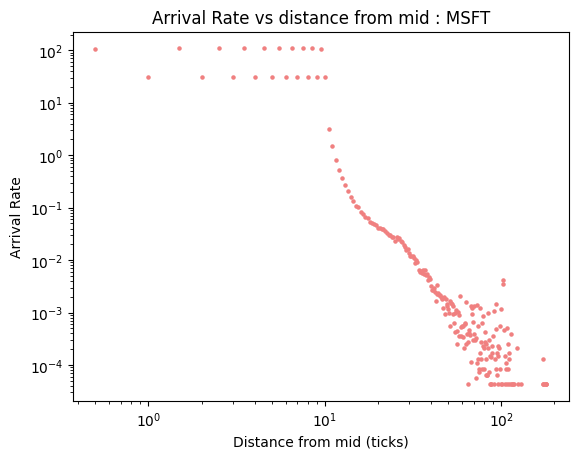

In [21]:
%matplotlib inline
plt.figure()
plt.scatter([i/2 for i in list(final_res.keys())], list(final_res.values()), s= 5, c= "lightcoral")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Distance from mid (ticks)")
plt.ylabel("Arrival Rate")
plt.title("Arrival Rate vs distance from mid : " + ric)
plt.savefig("/SAN/fca/Konark_PhD_Experiments/smallTick/"+ric+"_EDA_ArrivalRateVsDistanceFromMid.png")